# Model Training with K-Folds Cross-Validation

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Dict, Tuple

## Load Data

More information about the dataset can be found in UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Acknowledgement: Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg

In [3]:
# Download original dataset with: python src/pipelines/load_data.py 

raw_data = pd.read_csv(f"../data/raw_data.csv")

raw_data.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Define column mapping

In [4]:
target = 'cnt'
prediction = 'prediction'
datetime = 'dteday'
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'mnth', 'hr', 'weekday']
categorical_features = ['season', 'holiday', 'workingday', ]

# Define the comparison windows

In [5]:
start_date_0 = '2011-01-02 00:00:00'
end_date_0 = '2011-01-30 23:00:00'

experiment_batches = [
    
    ('2011-01-31 00:00:00','2011-02-06 23:00:00'),
    ('2011-02-07 23:00:00','2011-02-13 23:00:00'),
    ('2011-02-14 23:00:00','2011-02-20 23:00:00'),
    ('2011-02-21 00:00:00','2011-02-27 23:00:00'),
    ('2011-02-28 00:00:00','2011-03-06 23:00:00'),  
]

## Define the Reference data

In [6]:
# Set datetime index 
raw_data = raw_data.set_index('dteday')

# Define the reference dataset
reference = raw_data.loc[start_date_0:end_date_0]

print(reference.shape)
reference.head()

(617, 16)


instant  season  yr  mnth  hr  holiday  weekday  workingday  \
dteday                                                                    
2011-01-03       48       1   0     1   0        0        1           1   
2011-01-03       49       1   0     1   1        0        1           1   
2011-01-03       50       1   0     1   4        0        1           1   
2011-01-03       51       1   0     1   5        0        1           1   
2011-01-03       52       1   0     1   6        0        1           1   

            weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
dteday                                                                          
2011-01-03           1  0.22  0.1970  0.44     0.3582       0           5    5  
2011-01-03           1  0.20  0.1667  0.44     0.4179       0           2    2  
2011-01-03           1  0.16  0.1364  0.47     0.3881       0           1    1  
2011-01-03           1  0.16  0.1364  0.47     0.2836       0           3    3  
2011-01-03           1  0.14  0.1061  0.50     0.3881       0          30   30

## Train a model

# DVC Report

params.yaml

| model        |   random_state |   n_estimators |
|--------------|----------------|----------------|
| RandomForest |              0 |            100 |

metrics.json

|      me |    mae |   step |
|---------|--------|--------|
| 1573.74 | 20.557 |      4 |

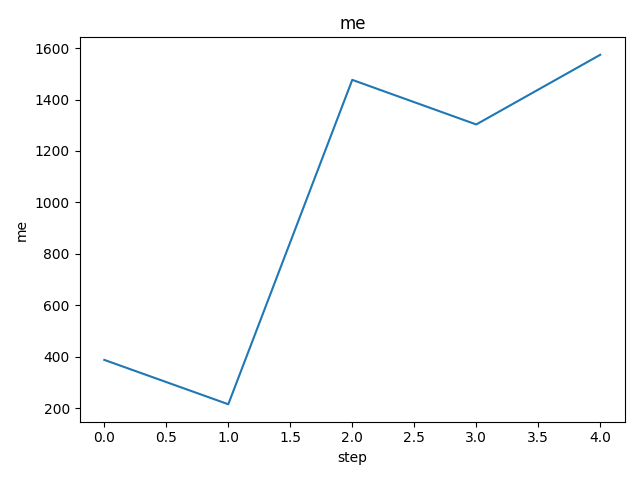

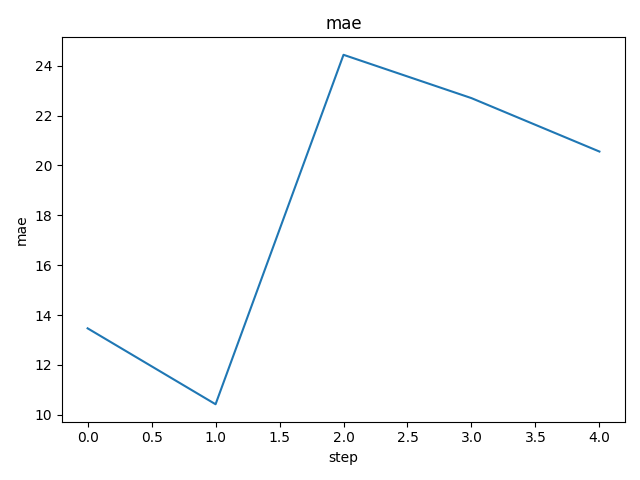


Step: 0
Train period: 2011-01-02 00:00:00 - 2011-01-30 23:00:00
Test period: 2011-01-31 00:00:00 - 2011-02-06 23:00:00


Step: 1
Train period: 2011-01-02 00:00:00 - 2011-02-06 23:00:00
Test period: 2011-02-07 23:00:00 - 2011-02-13 23:00:00


Step: 2
Train period: 2011-01-02 00:00:00 - 2011-02-13 23:00:00
Test period: 2011-02-14 23:00:00 - 2011-02-20 23:00:00


Step: 3
Train period: 2011-01-02 00:00:00 - 2011-02-20 23:00:00
Test period: 2011-02-21 00:00:00 - 2011-02-27 23:00:00


Step: 4
Train period: 2011-01-02 00:00:00 - 2011-02-27 23:00:00
Test period: 2011-02-28 00:00:00 - 2011-03-06 23:00:00


	notebooks/Untitled.ipynb


In [8]:
from dvclive import Live

# Set experiment variables
model_path = Path('../models/model.joblib')
ref_end_data = end_date_0

with Live(dir='../results/k-fold',
          save_dvc_exp=True,  # DVCLive will create a new DVC experiment 
          dvcyaml=True,
          report='notebook',  # Display a report in the Notebook
         ) as live:
    

    # Run model train for each batch (K-Fold)
    for k, date in enumerate(experiment_batches):

        print(f"Step: {k}")
        print(f"Train period: {start_date_0} - {ref_end_data}") 
        X_train = raw_data.loc[start_date_0:ref_end_data, numerical_features + categorical_features]
        y_train = raw_data.loc[start_date_0:ref_end_data, target]
        # print("X_train (reference) dataset shape: ", X_train.shape, y_train.shape)
        
        print(f"Test period: {date[0]} - {date[1]}") 
        current = raw_data.loc[date[0]:date[1]]
        X_test = current.loc[:, numerical_features + categorical_features]
        y_test = current[target]
        # print("X_test (current)) dataset shape: ",  X_test.shape, y_test.shape)
        
        # Update reference end date
        ref_end_data = date[1]
        
        # Set parameters
        random_state = 0
        n_estimators = 100
        
        # Train model
        regressor = ensemble.RandomForestRegressor(random_state = random_state, n_estimators = n_estimators)
        regressor.fit(X_train, y_train)
    
        # Calculate metrics
        preds = regressor.predict(X_test)
        me = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        # print(me, mae)
    

        # Log params 
        live.log_param('model', 'RandomForest') 
        live.log_params({'random_state': random_state, 'n_estimators': n_estimators})
    
        # Log metrics
        live.log_metric('me', round(me, 3))
        live.log_metric('mae', round(mae, 3))
        
        
        # Log RandomForestRegressor model
        live.log_artifact(
            path = '../models/model.joblib',
            type = 'model', 
            name = "random-forest", # Note: only lowercase letter
            desc = "This a model version 3 description added with update_model_version() method",
            labels=["RandomForestRegressor", "bike-sharing"],
            meta = {
                'features': list(X_test.columns),
                'me': str(round(me, 3)),         # Note: 'float' is not supported by 'dvc.yaml', convert to 'str'
                'mae': str(round(mae, 3))        # It's better to use 'log_metrics' or 'log_params' for float values
            },
            copy = True,
            cache  = True
        )

        # Signal that the current iteration has ended and increases step value by 1 (one).
        live.next_step()